## Import libraries

In [97]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu
from pyproj import Proj, Transformer, CRS
import seaborn as sns

# Import Planetary Computer tools
import pystac_client
import planetary_computer 
from odc.stac import stac_load
from tqdm import tqdm


## II. Data processing
### A. Import sentinel-2 and Landsat data

Let's define important parameters 

In [40]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define the time window
time_window = "2021-06-01/2021-09-01"

Get the data from source

In [270]:
def look_for_data(bounds, collections, query, datetime):
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    
    # Search for "lt- low cloud" with cloud cover <30%
    search = stac.search(
        bbox=bounds, 
        datetime=datetime,
        collections=collections,
        query=query,
    )
    
    # Get the number of items
    items = list(search.get_items())
    print('Number of scenes that touch our region:',len(items))
    
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    return items, signed_items

def get_data(bounds, collections, query, datetime, bands, resolution):
    items, signed_items = look_for_data(
        bounds=bounds,
        collections=collections,
        query=query,
        datetime=datetime
    )
    data = stac_load(
        items,
        bands=bands,
        crs="EPSG:4326", # Latitude-Longitude
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        dtype="float64",
        patch_url=planetary_computer.sign,
        bbox=bounds
    )
    print("Data loaded!")
    display(data)
    return data

raw_sen_data = get_data(
        bounds=bounds,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 30}},
        datetime=time_window,
        bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
        resolution=10/111320.0,
)

raw_land_data = get_data(
        bounds=bounds,
        collections=["landsat-c2-l2"],
        query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
        datetime=time_window,  
        bands=["lwir11"],
        resolution=30/111320.0,
)

Number of scenes that touch our region: 10
Data loaded!


<xarray.Dataset> Size: 2GB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) float64 194MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

Number of scenes that touch our region: 8
Data loaded!


<xarray.Dataset> Size: 17MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) float64 17MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

In [271]:
# Take
sen_data = raw_sen_data.median(dim="time").compute()

# Scale Factors for the Surface Temperature band
scale = 0.00341802 
offset = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
land_data = raw_land_data.astype(float) * scale + offset - kelvin_celsius

In [279]:
# Calculate NDBI for the median mosaic
ndbi_median = (sen_data.B11-sen_data.B08)/(sen_data.B11+sen_data.B08)
ndbi_median.dtype

dtype('float64')

In [280]:
def save_data(data, filename, bands, scene=None):
    if scene is not None:
        data_slice = data.isel(time=scene)
    else:
        data_slice = data  # Use the full dataset if no scene is specified

    # Calculate the dimensions of the file
    # height = median.dims["latitude"]
    # width = median.dims["longitude"]
    height = data_slice.dims["latitude"]
    width = data_slice.dims["longitude"]

    # Define the Coordinate Refeerence System (CRS) to be common Lat-Lon coordinates
    # Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
    gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width,height)
    data_slice.rio.write_crs("epsg:4326", inplace=True)
    data_slice.rio.write_transform(transform=gt, inplace=True);

    # Create the GeoTIFF output file using the defined parameters
    # Select 6 bands
    with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                    crs='epsg:4326',transform=gt,count=len(bands),compress='lzw',dtype='float64') as dst:
        for i, band in enumerate(bands, start=1):
            dst.write(getattr(data_slice, band), i)
        dst.close()
    return print("Operation completed!")

In [281]:
save_data(data=sen_data, filename="data/interim/Sen2.tiff", bands=["B01", "B02", "B03", "B04", "B06", "B08", "B11", "B12"])
save_data(data=land_data, filename="data/interim/Landsat_LST.tiff", scene=2, bands=["lwir11"])

Operation completed!
Operation completed!


### B. Data manipulation for model training

<h4 style="color:rgb(255, 255, 0)">1. Map satelitte data with the coordinates in the training file</h4>

In [282]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
def map_satellite_data(sen2_tiff_path, land_tiff_path, ground_df_path):
    """
    Load both sentinel-2 and land satellite data, extract required indices based on the
    latitute & longitude of the ground dataset.

    Parameters:
    sen2_tiff_path(string): file path to the sentinel-2 tiff dataset
    land_tiff_path(string): file path to the land satellite tiff dataset
    ground_df_path(string): file path to the ground dataset
    """
    
    # Load the GeoTIFF data
    sen_data = rxr.open_rasterio(sen2_tiff_path)
    land_data = rxr.open_rasterio(land_tiff_path)
    tiff_crs = sen_data.rio.crs

    # Read the ground_df, take lat & lon values from them
    df = pd.read_csv(ground_df_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)
    
    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B11_values = []
    B12_values = []
    L11_values = []
    
# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = sen_data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

        B02_value = sen_data.sel(x=lon, y=lat,  band=2, method="nearest").values
        B02_values.append(B02_value)
            
        B03_value = sen_data.sel(x=lon, y=lat, band=3, method="nearest").values
        B03_values.append(B03_value)
        
        B04_value = sen_data.sel(x=lon, y=lat, band=4, method="nearest").values
        B04_values.append(B04_value)
        
        B06_value = sen_data.sel(x=lon, y=lat, band=5, method="nearest").values
        B06_values.append(B06_value)
    
        B08_value = sen_data.sel(x=lon, y=lat, band=6, method="nearest").astype("float32").values
        B08_values.append(B08_value)
        
        B11_value = sen_data.sel(x=lon, y=lat, band=7, method="nearest").astype("float32").values
        B11_values.append(B11_value)
    
        B12_value = sen_data.sel(x=lon, y=lat, band=8, method="nearest").astype("float32").values
        B12_values.append(B12_value)
        
        L11_value = land_data.sel(x=lon, y=lat, band=1, method="nearest").values
        L11_values.append(L11_value)

    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    df['B11'] = B11_values
    df['B12'] = B12_values
    df['L11'] = L11_values
    
    return df


In [283]:
sat_data = map_satellite_data(
    sen2_tiff_path='data/interim/Sen2.tiff', 
    land_tiff_path = "data/interim/Landsat_LST.tiff",
    ground_df_path='data/raw/Training_data_uhi_index_2025-02-18.csv'
)

Mapping values: 100%|██████████| 11229/11229 [00:26<00:00, 423.21it/s]


In [284]:
# Define the indices calculations
indices = {
    "NDVI": (sat_data["B08"] - sat_data["B04"]) / (sat_data["B08"] + sat_data["B04"]),
    "NDBI": (sat_data["B11"].astype("float64") - sat_data["B08"].astype("float64")) / (sat_data["B11"].astype("float64") + sat_data["B08"].astype("float64")),
    "NDWI": (sat_data["B03"] - sat_data["B08"]) / (sat_data["B03"] + sat_data["B08"]),
    "EVI": 2.5 * (sat_data["B08"] - sat_data["B04"]) / (sat_data["B08"] + 6 * sat_data["B04"] - 7.5 * sat_data["B02"] + 1),
    "SAVI": ((sat_data["B08"] - sat_data["B04"]) / (sat_data["B08"] + sat_data["B04"] + 0.5)) * 1.5,
    "NBAI": ((sat_data["B11"] + sat_data["B12"]) - sat_data["B08"]) / ((sat_data["B11"] + sat_data["B12"]) + sat_data["B08"])

}

# Compute and clean each index dynamically
for index_name, index_value in indices.items():
    sat_data[index_name] = index_value.replace([np.inf, -np.inf], np.nan).astype("float64")

In [285]:
sat_data

,B01,B02,B03,B04,B06,B08,B11,B12,L11,NDVI,NDBI,NDWI,EVI,SAVI,NBAI
0,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,1792.0,1495.5,38.393941100000006,0.206057,-0.011038,-0.226649,1.335894,0.309034,0.284305
1,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,1792.0,1495.5,38.393941100000006,0.206057,-0.011038,-0.226649,1.335894,0.309034,0.284305
2,841.5,646.0,823.0,777.0,1883.0,2241.0,1548.0,1135.0,37.78553354000002,0.485089,-0.182898,-0.462794,1.777562,0.727514,0.089764
3,841.5,625.0,766.0,741.5,1883.0,2200.0,1548.0,1135.0,37.78553354000002,0.495835,-0.173959,-0.483479,1.857962,0.743627,0.098915
4,841.5,659.5,763.0,708.5,1783.0,2161.0,1617.5,1207.5,37.35828104000001,0.506186,-0.143840,-0.478112,2.475712,0.759146,0.133173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,462.5,491.0,725.5,501.0,2612.0,3152.0,1925.0,1072.5,30.29323370000003,0.725705,-0.241678,-0.625790,2.676156,1.088408,-0.025124
11225,462.5,506.5,741.5,551.5,2612.0,3572.0,1925.0,1072.5,30.29323370000003,0.732509,-0.299618,-0.656196,2.449120,1.098630,-0.087450
11226,462.5,506.5,741.5,551.5,2612.0,3572.0,1925.0,1072.5,30.44020856000003,0.732509,-0.299618,-0.656196,2.449120,1.098630,-0.087450
11227,462.5,506.5,741.5,551.5,2612.0,3572.0,1925.0,1072.5,30.44020856000003,0.732509,-0.299618,-0.656196,2.449120,1.098630,-0.087450


Load ground data and combine with the sentinel-2 dataset

In [286]:
# Load ground dataset
ground_df = pd.read_csv("data/interim/ground_df.csv")
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
satground_df = pd.concat([ground_df,sat_data], axis=1)
satground_df.head()

,Longitude,Latitude,datetime,UHI Index,building_coverage,B01,B02,B03,B04,B06,B08,B11,B12,L11,NDVI,NDBI,NDWI,EVI,SAVI,NBAI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.000006,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,1792.0,1495.5,38.393941100000006,0.206057,-0.011038,-0.226649,1.335894,0.309034,0.284305
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.000006,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,1792.0,1495.5,38.393941100000006,0.206057,-0.011038,-0.226649,1.335894,0.309034,0.284305
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.000006,841.5,646.0,823.0,777.0,1883.0,2241.0,1548.0,1135.0,37.78553354000002,0.485089,-0.182898,-0.462794,1.777562,0.727514,0.089764
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.000006,841.5,625.0,766.0,741.5,1883.0,2200.0,1548.0,1135.0,37.78553354000002,0.495835,-0.173959,-0.483479,1.857962,0.743627,0.098915
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.000006,841.5,659.5,763.0,708.5,1783.0,2161.0,1617.5,1207.5,37.35828104000001,0.506186,-0.143840,-0.478112,2.475712,0.759146,0.133173


*We now have `satground_data` - a combination of the ground UHI data and the sentinel-2 indices data

<h4 style="color:rgb(255, 255, 0)">2. Map `NY_Mesonet_Weather` data with our `satground_data`</h4>

Load `New York Mesonet Weather` data then merge them together

In [287]:
# Ensure file path is correct
path = "data/raw/NY_Mesonet_Weather.xlsx"
bronx_weather = pd.read_excel(f"{path}", sheet_name="Bronx", engine="openpyxl")
manhattan_weather = pd.read_excel(f"{path}", sheet_name="Manhattan", engine="openpyxl")

In [288]:
# Define function to classify borough
def classify_location(lat, lon):
    if 40.70 <= lat <= 40.88 and -74.01 <= lon <= -73.90:
        return "Manhattan"
    elif 40.78 <= lat <= 40.91 and -73.93 <= lon <= -73.78:
        return "Bronx"
    else:
        return "Unknown"

# Apply function to dataset
satground_df['location'] = satground_df.apply(lambda row: classify_location(row['Latitude'], row['Longitude']), axis=1)

# Make a copy to merge weather data
satground_df2 = satground_df.copy()

satground_df.head()

,Longitude,Latitude,datetime,UHI Index,building_coverage,B01,B02,B03,B04,B06,...,B11,B12,L11,NDVI,NDBI,NDWI,EVI,SAVI,NBAI,location
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.000006,841.5,1053.0,1155.0,1206.0,1660.5,...,1792.0,1495.5,38.393941100000006,0.206057,-0.011038,-0.226649,1.335894,0.309034,0.284305,Manhattan
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.000006,841.5,1053.0,1155.0,1206.0,1660.5,...,1792.0,1495.5,38.393941100000006,0.206057,-0.011038,-0.226649,1.335894,0.309034,0.284305,Manhattan
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.000006,841.5,646.0,823.0,777.0,1883.0,...,1548.0,1135.0,37.78553354000002,0.485089,-0.182898,-0.462794,1.777562,0.727514,0.089764,Manhattan
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.000006,841.5,625.0,766.0,741.5,1883.0,...,1548.0,1135.0,37.78553354000002,0.495835,-0.173959,-0.483479,1.857962,0.743627,0.098915,Manhattan
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.000006,841.5,659.5,763.0,708.5,1783.0,...,1617.5,1207.5,37.35828104000001,0.506186,-0.143840,-0.478112,2.475712,0.759146,0.133173,Manhattan


Let's manipulate the `Mesonet weather data` then merge their data with our `satground` dataset

In [289]:
# Rename the column to 'datetime'
bronx_weather = bronx_weather.rename(columns={"Date / Time": "datetime"})
manhattan_weather = manhattan_weather.rename(columns={"Date / Time": "datetime"})

In [290]:
# Convert satground_df to datetime dtype
satground_df2['datetime'] = pd.to_datetime(satground_df2['datetime'], format='%d-%m-%Y %H:%M')
# Convert weather data to datetime dtype, remove timezone sign
bronx_weather['datetime'] = pd.to_datetime(bronx_weather['datetime']).dt.tz_localize(None)
manhattan_weather['datetime'] = pd.to_datetime(manhattan_weather['datetime']).dt.tz_localize(None)

# Add 'location' column to weather DataFrames
bronx_weather['location'] = 'Bronx'
manhattan_weather['location'] = 'Manhattan'

# Concatenate both weather datasets
weather_df = pd.concat([bronx_weather, manhattan_weather])

# Ensure all DataFrames are sorted by datetime
satground_df2 = satground_df2.sort_values('datetime')
weather_df = weather_df.sort_values('datetime')

# Merge using 'Datetime' and 'location'
uhi_data = pd.merge_asof(satground_df2, weather_df, on='datetime', by='location')

# Check the final DataFrame
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,building_coverage,B01,B02,B03,B04,B06,...,NDWI,EVI,SAVI,NBAI,location,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-73.977157,40.771555,2021-07-24 15:01:00,0.975234,4.248421e-07,485.0,1106.0,1266.0,1392.0,2175.0,...,-0.223551,0.734291,0.267011,0.305725,Manhattan,26.1,51.1,4.1,139,140
1,-73.910167,40.803775,2021-07-24 15:01:00,1.000718,2.952757e-06,1319.5,1356.0,1486.0,1548.0,1578.5,...,-0.049264,0.303030,0.043281,0.350302,Manhattan,26.1,51.1,4.1,139,140
2,-73.910268,40.803817,2021-07-24 15:01:00,1.000718,2.952757e-06,1319.5,1339.0,1405.0,1540.0,1578.5,...,-0.080497,0.326663,0.052170,0.347366,Manhattan,26.1,51.1,4.1,139,140
3,-73.978742,40.771675,2021-07-24 15:01:00,0.975234,1.083310e-05,469.0,529.5,667.0,558.5,2221.5,...,-0.620051,2.568266,1.007420,-0.036538,Manhattan,26.1,51.1,4.1,139,140
4,-73.978453,40.771677,2021-07-24 15:01:00,0.970907,4.248421e-07,400.5,418.5,509.5,413.5,2277.5,...,-0.676045,2.807250,1.093033,-0.013067,Manhattan,26.1,51.1,4.1,139,140


In [291]:
uhi_data.describe()

,Longitude,Latitude,datetime,UHI Index,building_coverage,NDVI,NDBI,NDWI,EVI,SAVI,NBAI,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
count,11229.000000,11229.000000,11229,11229.000000,1.122900e+04,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,-73.933927,40.808800,2021-07-24 15:34:29.056906240,1.000001,8.097158e-06,0.206853,0.009703,-0.225783,1.039231,0.310233,0.299228,26.883881,47.829103,2.982251,168.410633,462.831419
min,-73.994457,40.758792,2021-07-24 15:01:00,0.956122,2.370098e-08,-0.164700,-0.443110,-0.806583,-194.000000,-0.246934,-0.272472,26.100000,40.200000,1.400000,91.000000,128.000000
25%,-73.955703,40.790905,2021-07-24 15:22:00,0.988577,5.875661e-06,0.053281,-0.063419,-0.309578,0.340114,0.079909,0.233636,26.600000,46.700000,2.500000,154.000000,349.000000
50%,-73.932968,40.810688,2021-07-24 15:36:00,1.000237,8.173191e-06,0.129202,0.024390,-0.165601,0.828185,0.193781,0.327112,26.800000,47.600000,3.200000,163.000000,511.000000
75%,-73.909647,40.824515,2021-07-24 15:48:00,1.011176,1.038176e-05,0.295107,0.096386,-0.095206,1.700381,0.442593,0.397325,27.200000,49.700000,3.500000,196.000000,605.000000
max,-73.879458,40.859497,2021-07-24 15:59:00,1.046036,1.634728e-05,0.882879,0.558525,0.187701,89.375000,1.324145,0.746920,28.300000,51.100000,4.500000,209.000000,725.000000
std,0.028253,0.023171,NaN,0.016238,3.685329e-06,0.206192,0.132000,0.175793,4.297828,0.309245,0.146793,0.377049,2.069172,0.707952,26.595379,181.776334


Drop duplicates

In [292]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = uhi_data.drop(columns=['Longitude', 'Latitude', 'datetime', 'UHI Index']).columns
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.describe()

,Longitude,Latitude,datetime,UHI Index,building_coverage,B01,B02,B03,B04,B06,...,NDBI,NDWI,EVI,SAVI,NBAI,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
count,9039.000000,9039.000000,9039,9039.000000,9.039000e+03,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,...,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000,9039.000000
mean,-73.933752,40.808551,2021-07-24 15:34:13.096581376,0.999905,8.074978e-06,1194.227735,1206.284213,1345.808773,1414.239020,2017.982741,...,0.010745,-0.224170,1.059212,0.307391,0.300596,26.886237,47.828720,2.979611,168.013608,463.111959
min,-73.994457,40.758792,2021-07-24 15:01:00,0.956122,2.370098e-08,243.500000,266.000000,320.000000,222.500000,513.500000,...,-0.443110,-0.806583,-194.000000,-0.246934,-0.272472,26.100000,40.200000,1.400000,91.000000,128.000000
25%,-73.955895,40.790680,2021-07-24 15:22:00,0.988637,5.866523e-06,968.500000,907.250000,1035.000000,1070.000000,1693.500000,...,-0.060825,-0.306759,0.342996,0.080259,0.235493,26.600000,46.700000,2.500000,154.000000,349.000000
50%,-73.932738,40.810362,2021-07-24 15:35:00,1.000358,8.173191e-06,1182.000000,1148.000000,1273.000000,1364.000000,1966.500000,...,0.024860,-0.165507,0.822953,0.194006,0.327431,26.800000,47.600000,3.200000,163.000000,511.000000
75%,-73.909274,40.823394,2021-07-24 15:48:00,1.011056,1.038176e-05,1419.000000,1400.000000,1547.000000,1678.000000,2280.500000,...,0.096490,-0.095465,1.698464,0.439384,0.397229,27.200000,49.700000,3.500000,196.000000,605.000000
max,-73.879458,40.859495,2021-07-24 15:59:00,1.046036,1.634728e-05,2671.500000,5256.000000,5444.000000,5578.000000,4783.500000,...,0.558525,0.187701,89.375000,1.324145,0.746920,28.300000,51.100000,4.500000,209.000000,725.000000
std,0.028487,0.023014,NaN,0.016220,3.677446e-06,364.477199,498.019531,509.838653,579.004136,477.895507,...,0.130416,0.173444,4.126100,0.304934,0.144598,0.382183,2.100973,0.710409,26.744609,181.330057


<h4 style="color:rgb(255, 255, 0)">3. Correlation check</h4>

Text(0.5, 1.0, 'Correlation between the variables of the UHI dataset')

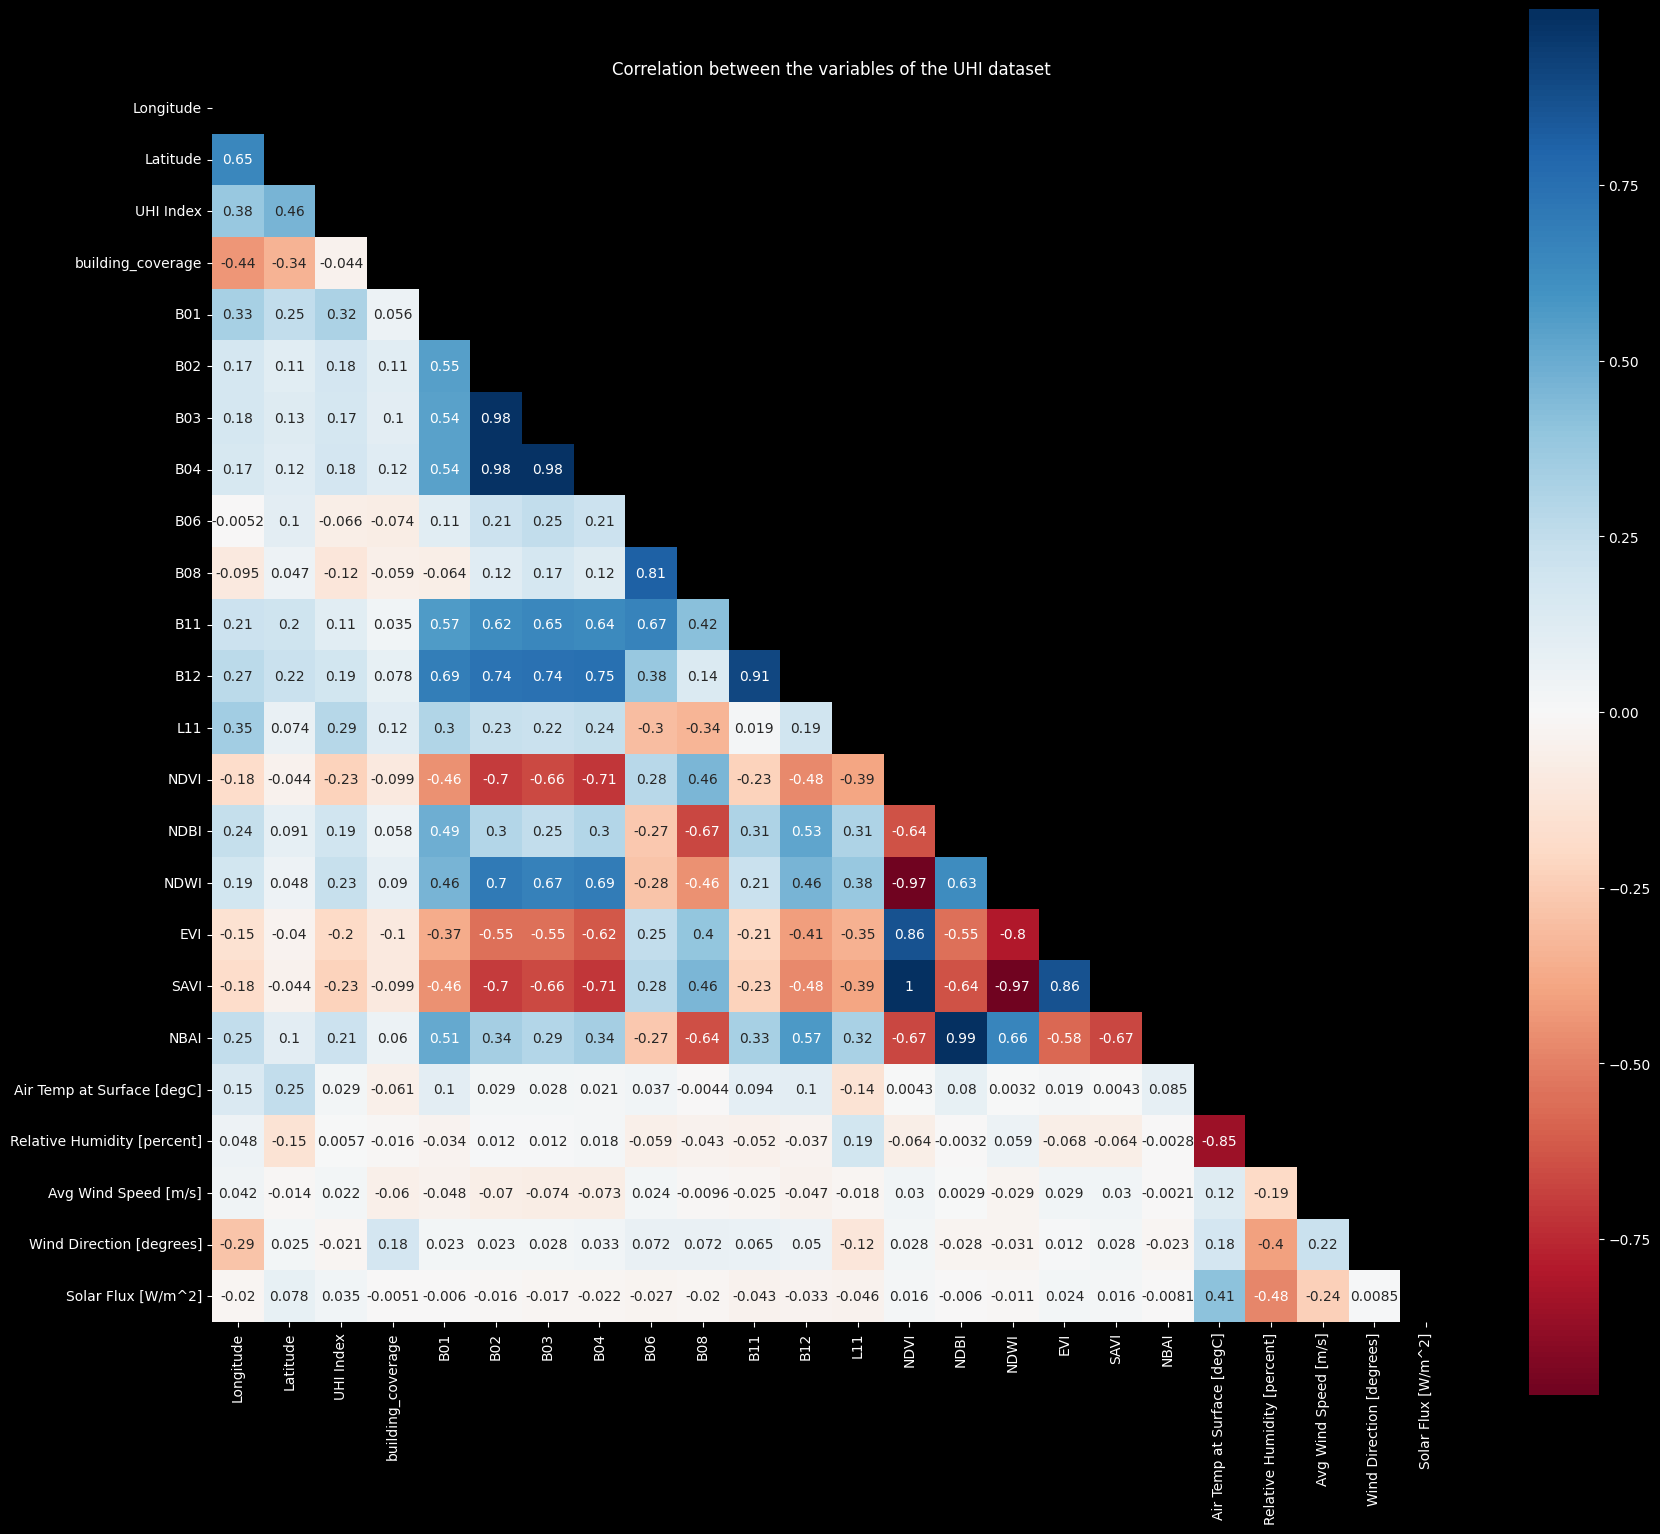

In [293]:
# Calculate correlation between all of the variables using `spearman` method
corr = uhi_data.drop(columns=['datetime', 'location']).corr(method = 'spearman')
corr

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.style.use("dark_background")
plt.subplots
f, ax = plt.subplots(figsize=(20, 18))


# Visualize with a correlation matrix heatmap
sns.heatmap(
    corr,
    annot = True,
    mask = mask,
    center = 0,
    square = True,
    cmap = "RdBu",
    xticklabels = 'auto',
)

plt.title('Correlation between the variables of the UHI dataset',)

In [294]:
uhi_data.to_csv('data/processed/uhi_data.csv')

## Machine Learning

In [299]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
train_data = uhi_data.drop(columns=['Longitude', 'Latitude', 'datetime', 'location'])

In [353]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Split the data into features (X) and target (y), and then into training and testing sets
X = train_data.drop(columns=['UHI Index']).values
y = train_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [369]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [362]:
import re
import xgboost as xgb  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

In [368]:
# 4. Initialize the final XGBoost model with the best hyperparameters
model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    max_depth=10,              # Best max_depth from tuning
    subsample=1.0,             # Best subsample from tuning
    min_child_weight=3,        # Best min_child_weight from tuning
    colsample_bytree=1.0,      # Best colsample_bytree from tuning
    learning_rate=0.15,        # Best learning_rate from tuning
    n_estimators=500           # Keep the number of estimators high for final model
)

# 5. Train the final XGBoost model
model.fit(X_train, y_train)

# 6. Predict on the validation set
y_pred_xgb_final = model.predict(X_train)

# 7. Evaluate performance of the final model
#print("MAE train (final XGBoost):", mean_absolute_error(Y_train, y_pred_xgb_final))
print("R² Score train (final XGBoost):", r2_score(Y_train, y_pred_xgb_final))

# 6. Predict on the validation set
y_pred_xgb_final = model.predict(X_test)

# 7. Evaluate performance of the final model
#print("MAE (final XGBoost):", mean_absolute_error(Y_test, y_pred_xgb_final))
print("R² Score (final XGBoost):", r2_score(Y_test, y_pred_xgb_final))

R² Score train (final XGBoost): 0.9942435622215271
R² Score (final XGBoost): 0.8597305417060852


In [370]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9766673242222088

In [356]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8455485465116128

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template.csv')
test_file.head()

# Mapping satellite data for submission.
val_data = map_satellite_data('S2_sample.tiff', 'Submission_template.csv')